## DEPENDENCIES

Uncomment the following pip commands to install the necessary dependencies if it is the first time run.
Then, reset the runtime and do not run the pip installs again.

In [ ]:
!pip install --user -U nltk
!pip install -U deep-translator
!pip install tqdm_notebook
!pip install pyldavis
!pip install vadersentiment

In [ ]:
from deep_translator import GoogleTranslator
from matplotlib import pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import PorterStemmer
import gensim
import pyLDAvis
import pyLDAvis.gensim
import re
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## IMPORT DATA

In [ ]:
df = pd.read_excel("Viva-Tec-data.xlsx", sheet_name="Checkin")
df.rename({'translation': 'Comment'}, axis=1, inplace=True)
df = df.iloc[:200,:] # Average per day is 200 reviews
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,nps,Comment
0,2023-04-17 20:23:04,9,PRECIO
1,2023-04-17 20:21:04,9,ES LA PRIMERA VEZ Y SI ME SIENTO CON ALGO DE I...
2,2023-04-17 20:17:07,9,Es muy rapido
3,2023-04-17 20:17:04,10,Bueno
4,2023-04-17 20:10:06,9,Prcticidad
...,...,...,...
195,2023-04-16 01:40:41,10,por que es muy ágil
196,2023-04-16 01:37:29,10,FUE MUY RAPIDO
197,2023-04-16 01:33:18,10,Buen precio y eficiente
198,2023-04-16 01:25:05,9,eficacia


## EXPLORATION

In [ ]:
unique = []

for i, text in enumerate(df["Comment"]):
  text = str(text).lower()
  x = len(text.split())
  if x == 1 and len(text) < 4:
    if text not in unique:
      unique.append(text)

print(len(unique))
print(unique)

9
['.', 'si', ':d', 'na', 'b', 'ok', 'm', ':)', 'no']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NPS Score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([ 44.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 156.]),
 array([ 9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. ]),
 <BarContainer object of 10 artists>)

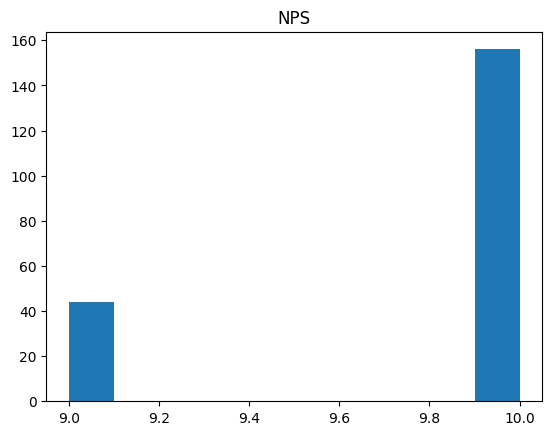

In [ ]:
plt.title("NPS")
plt.hist(df["nps"])

In [ ]:
promoters_count = len(df[df.nps >= 9])
promoters = promoters_count / len(df)

detractors_count = len(df[df.nps <= 6])
detractors = detractors_count / len(df)

nps_score = (promoters - detractors) * 100
print("Weighted NPS score = {}".format(nps_score))
print("NPS Score = %promoters(10-9) - %ditractor(>6)")

Weighted NPS score = 100.0
NPS Score = %promoters(10-9) - %ditractor(>6)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### TIME

In [ ]:
def removeTime(row):
  return row.date()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_time = df.copy()
df_time['Date'] = pd.to_datetime(df_time.Date)
df_time['Date'] = df_time.Date.apply(removeTime)
df_time = df_time.groupby(['Date']).count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_time = df_time.drop("Comment", axis=1)
df_time.rename({'nps': 'Reviews'}, axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-42-888df913a8a3>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)


[Text(19463.0, 0, '04-16 00'),
 Text(19463.125, 0, '04-16 03'),
 Text(19463.25, 0, '04-16 06'),
 Text(19463.375, 0, '04-16 09'),
 Text(19463.5, 0, '04-16 12'),
 Text(19463.625, 0, '04-16 15'),
 Text(19463.75, 0, '04-16 18'),
 Text(19463.875, 0, '04-16 21'),
 Text(19464.0, 0, '04-17 00')]

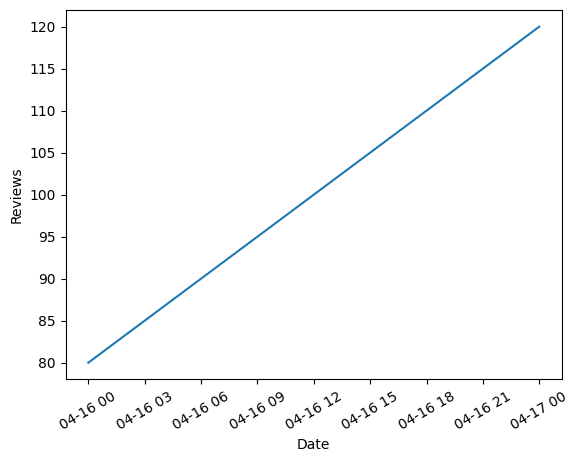

In [ ]:
line_plot = sns.lineplot(data=df_time, x="Date", y="Reviews")
line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)

In [ ]:
daily_average = sum(df_time.Reviews)/df_time.shape[0]
daily_average

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100.0

## PRE-PROCESSING

###Filter: spanish

In this step any entries below 3 characters are inspected to certify they contain relevant information and not just trash data like empty text, periods or such. Additionally, the data can contain irregular characters such as emojis or emoticons that can convey relevant customer data. These responses are mapped to equivalent emotions to be analyzed by sentiment. This section also calcultes the mean length of entries and removes empty or useless data.

In [ ]:
avg = 0
max_len = 0
min_len = 1000000

# Declare tokens of lenght less than 3 that are considered relevant feedback
desired_tokens = ["si", "no", "ok"]
# Converte emojis and emoticons to quantifiable and manageable data based on type of reaction
happy_emojis = [":)", "(:", "(;", '👍', ";)", ";D", ":D", "😊", "=)", "😇", "👌🏻"]
sad_emojis = ["=(", ":/", "):", ":(", ");", ";(", "🙁","😭","😢"]
drop_list = []

for i, text in enumerate(df["Comment"]):
  text = str(text).lower()
  x = len(text.split())
  if text in happy_emojis:
    df.loc[i, "Comment"] = "feliz"
  elif text in sad_emojis:
    df.loc[i, "Comment"] = "triste"
  elif x == 1 and len(text) < 3 and text not in desired_tokens:
      drop_list.append(i)
      continue
  avg += x
  if x > max_len:
    max_len = x
  elif x < min_len:                                     
    min_len = x

avg /= len(df["Comment"])
print("LENGTH\nAvg = {} / Max {} / Min {}\n".format(avg, max_len, min_len))
print("DROP\nDrop {} invalid reviews".format(len(drop_list)))
print("NaN comments dropped {}".format(df['Comment'].isna().sum()))

LENGTH
Avg = 3.795 / Max 29 / Min 1

DROP
Drop 9 invalid reviews
NaN comments dropped 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove trash entries or nonsensical input
df = df.drop(labels=drop_list)
df = df.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Translation

The processed data is loaded into the Google Translate library to translate all comments from spanish to english. Any comments written in english are skipped. This is done because the sentiment analysis models are trained using text in english.

In [ ]:
def translate(row):
  r = str(row)
  try:
    t  = GoogleTranslator(source='es', target='en').translate(str(r))
    return t
  except:
    return "NVT"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['translation'] = df.Comment.progress_apply(translate)
df = df.drop(axis = 1, labels = 'Comment') 
df.rename({'translation': 'Comment'}, axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/191 [00:00<?, ?it/s]

###Filter: english

The translated model is once again filtered to ensure only relevant entries are considered and included in the following sentiment analysis and topic modeling. It is important to note that for sentiment analysis, the processed data is input directly with punctuation and capitalization in order to extract the most accurate interpretation. On the other hand, topic modeling is done with the simplified, tokenized words in order to focus entirely on the core ideas.

In [ ]:
avg = 0
max_len = 0
min_len = 1000000

# Declare tokens of lenght less than 3 that are considered relevant feedback
desired_tokens = ["no", "ok", "wow", "lol", "all", "wow", "bye", "sad"]
# Converte emojis and emoticons to quantifiable and manageable data based on type of reaction
happy_emojis = [":)", "(:", "(;", '👍', ";)", ";D", ":D", "😊", "=)", "😇", "👌🏻"]
sad_emojis = ["=(", ":/", "):", ":(", ");", ";(", "🙁","😭","😢"]
drop_list = []

for i, text in enumerate(df["Comment"]):
  text = str(text).lower()
  x = len(text.split())
  if text in happy_emojis:
    df.loc[i, "Comment"] = "feliz"
  elif text in sad_emojis:
    df.loc[i, "Comment"] = "triste"
  elif x == 1 and len(text) < 4 and text not in desired_tokens:
      drop_list.append(i)
      continue
  avg += x
  if x > max_len:
    max_len = x
  elif x < min_len:                                     
    min_len = x

avg /= len(df["Comment"])
print("LENGTH\nAvg = {} / Max {} / Min {}\n".format(avg, max_len, min_len))
print("DROP\nDrop {} invalid reviews".format(len(drop_list)))
print("NaN comments dropped {}".format(df['Comment'].isna().sum()))

LENGTH
Avg = 4.0837696335078535 / Max 33 / Min 1

DROP
Drop 0 invalid reviews
NaN comments dropped 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenization & Remove Stopwords

In order to perform topic modeling, the processed comments are tokenized (separated into individual words) and the stop words are removed. Stop words are unnecesary connecting words, prepositions or other words without key value. These are removed to get a clearer understanding of the core ideas included in the dataset. 

In [ ]:
# Get list of stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('easy')

df_stop = df.copy()
stop_series = []
filtered = []

# Use regex to remove punctuation and tokenize
for i, text in enumerate(df['Comment']):
  text = re.sub(r'[^\w\s]', '', text)
  word_tokens = str(text).split()

  filtered = []
  for w in word_tokens:
    if w.lower() not in stop_words:
      filtered.append(w.lower())
  
  stop_series.append(filtered)

df_stop['Filtered'] = stop_series

df_stop

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,nps,Comment,Filtered
0,2023-04-17 20:23:04,9,PRICE,[price]
1,2023-04-17 20:21:04,9,THIS IS THE FIRST TIME AND IF I FEEL SOMETHING...,"[first, time, feel, something, insertion, well]"
2,2023-04-17 20:17:07,9,It's very fast,[fast]
3,2023-04-17 20:17:04,10,Well,[well]
4,2023-04-17 20:10:06,9,practicality,[practicality]
...,...,...,...,...
195,2023-04-16 01:40:41,10,because it is very agile,[agile]
196,2023-04-16 01:37:29,10,IT WAS VERY FAST,[fast]
197,2023-04-16 01:33:18,10,Good price and efficient,"[good, price, efficient]"
198,2023-04-16 01:25:05,9,effectiveness,[effectiveness]


## TOPIC MODELING

Topic modeling analyzes how often different words appear together and creates topics based on the frequency of specific words appearing together. In order to do this, the previously tokenized words are lemmatized in order to remove the temporal tense of the word, as well as removing any words smaller than 2 letters. These words are then used to create a dictionary of the different relations between words, which is then analyzed using a Latent Dirichlet Allocation algorithm to extract the desired topics.

In [ ]:
corpus = []
stem = PorterStemmer()
lem = nltk.WordNetLemmatizer()

for tokens in df_stop['Filtered']:
  words = [lem.lemmatize(w.lower()) for w in tokens if len(w) > 2]

  corpus.append(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics = 8,
                                       id2word = dic,
                                       passes = 5,
                                       workers = 2)
lda_model.show_topics() 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.077*"time" + 0.039*"first" + 0.027*"changed" + 0.027*"viva" + 0.027*"travel" + 0.027*"website" + 0.016*"good" + 0.014*"price" + 0.014*"clear" + 0.014*"200"'),
 (1,
  '0.244*"use" + 0.170*"efficient" + 0.028*"procedure" + 0.028*"airport" + 0.028*"avoid" + 0.028*"easily" + 0.028*"reliable" + 0.008*"simple" + 0.005*"service" + 0.004*"fast"'),
 (2,
  '0.239*"speed" + 0.046*"fly" + 0.046*"yeah" + 0.025*"everything" + 0.025*"well" + 0.025*"far" + 0.025*"worked" + 0.025*"without" + 0.025*"hassle" + 0.025*"explained"'),
 (3,
  '0.316*"fast" + 0.055*"airline" + 0.034*"clear" + 0.034*"best" + 0.034*"mexico" + 0.032*"everything" + 0.025*"page" + 0.023*"cost" + 0.023*"low" + 0.023*"check"'),
 (4,
  '0.223*"good" + 0.152*"service" + 0.041*"time" + 0.041*"price" + 0.028*"due" + 0.028*"line" + 0.028*"efficiency" + 0.015*"long" + 0.015*"traveled" + 0.015*"along"'),
 (5,
  '0.173*"simple" + 0.060*"quick" + 0.041*"information" + 0.039*"practicality" + 0.030*"okay" + 0.022*"almost" + 0.022*"hou

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.229478  0.126191       1        1  18.408693
0     -0.029445 -0.112080       2        1  17.875788
4     -0.181491  0.078589       3        1  15.224044
7     -0.107708  0.115820       4        1  12.051896
5      0.033687 -0.131455       5        1  11.000793
6      0.015576  0.085414       6        1   9.418248
2      0.034670 -0.053407       7        1   8.418504
1      0.005233 -0.109071       8        1   7.602034, topic_info=            Term       Freq      Total Category  logprob  loglift
7           fast  21.000000  21.000000  Default  30.0000  30.0000
25          good  13.000000  13.000000  Default  29.0000  29.0000
26       service  18.000000  18.000000  Default  28.0000  28.0000
24         speed   7.000000   7.000000  Default  27.0000  27.0000
10           use   7.000000   7.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
8   practicality   0.083827   2.177674   Topic8  -5.7573  -0.6805
29          yeah   0.083827   2.005935   Topic8  -5.7573  -0.5984
92    efficiency   0.083826   2.109212   Topic8  -5.7573  -0.6486
30       airline   0.083826   4.813623   Topic8  -5.7573  -1.4737
70          okay   0.083826   2.118736   Topic8  -5.7573  -0.6531

[360 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
123       2  0.672253         200
49        3  0.711938      access
130       5  0.693917  additional
64        2  0.672253     aerobus
34        6  0.780778       agile
...     ...       ...         ...
51        4  0.704288       whole
23        7  0.739646     without
63        7  0.739646      worked
29        7  0.498521        yeah
109       1  0.715494         yes

[171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 8, 6, 7, 3, 2])

In [ ]:
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(191, 3)

# VADER

In [ ]:
def getSentiment(comment):
  try:
    # Create the object analyzer
    sent_obj = SentimentIntensityAnalyzer()
    #Create the dictionary with the polarity values for the sentence
    sent_dictionary = sent_obj.polarity_scores(comment)
    #Return the compounded sentiment value
    return(sent_dictionary['compound'])
  except:
    print(comment)
    return -10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['vader_sentiment'] = df.Comment.progress_apply(getSentiment)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/191 [00:00<?, ?it/s]

In [ ]:
dates = df.copy()
dates['Date'] = pd.to_datetime(dates.Date)
dates['Date'] = dates.Date.apply(removeTime)
dates.columns
dates = dates.drop(labels= ['Comment', 'nps'], axis = 1)
dates = dates.groupby(['Date']).mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-58-451280906579>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)


[Text(19463.0, 0, '04-16 00'),
 Text(19463.125, 0, '04-16 03'),
 Text(19463.25, 0, '04-16 06'),
 Text(19463.375, 0, '04-16 09'),
 Text(19463.5, 0, '04-16 12'),
 Text(19463.625, 0, '04-16 15'),
 Text(19463.75, 0, '04-16 18'),
 Text(19463.875, 0, '04-16 21'),
 Text(19464.0, 0, '04-17 00')]

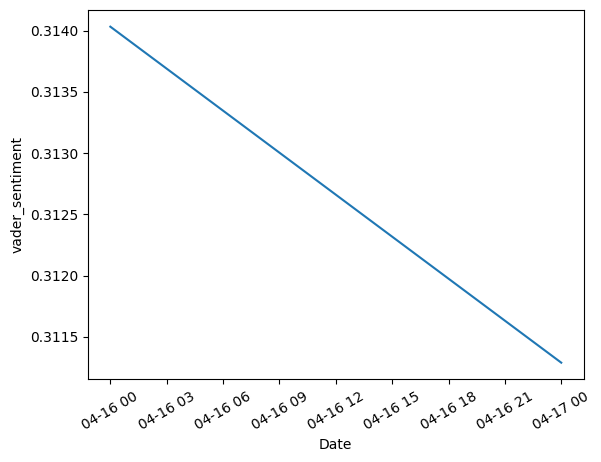

In [ ]:
line_plot = sns.lineplot(data=dates, x="Date", y="vader_sentiment")
line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)